# Statement

The Sure Tomorrow insurance company wants to solve several tasks with the help of Machine Learning and you are asked to evaluate that possibility.

- Task 1: Find customers who are similar to a given customer. This will help the company's agents with marketing.
- Task 2: Predict whether a new customer is likely to receive an insurance benefit. Can a prediction model do better than a dummy model?
- Task 3: Predict the number of insurance benefits a new customer is likely to receive using a linear regression model.
- Task 4: Protect clients' personal data without breaking the model from the previous task. It's necessary to develop a data transformation algorithm that would make it hard to recover personal information if the data fell into the wrong hands. This is called data masking, or data obfuscation. But the data should be protected in such a way that the quality of machine learning models doesn't suffer. You don't need to pick the best model, just prove that the algorithm works correctly.

# Data Preprocessing & Exploration

## Initialization

In [1]:
pip install scikit-learn --upgrade

In [2]:
import numpy as np
import pandas as pd

import seaborn as sns

import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing

from sklearn.model_selection import train_test_split

from sklearn.neighbors import NearestNeighbors,KNeighborsClassifier
from sklearn.linear_model import LinearRegression

from IPython.display import display

import math
# const random_state 
RANDOM_STATE = 12345

## Load Data

Load data and conduct a basic check that it's free from obvious issues.

In [3]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/insurance_us.csv')

We rename the colums to make the code look more consistent with its style.

In [4]:
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [5]:
df.sample(10)

,gender,age,income,family_members,insurance_benefits
1223,0,33.0,42400.0,0,0
2620,1,32.0,33300.0,2,0
3954,0,40.0,34700.0,2,0
93,1,20.0,25700.0,4,0
4414,0,27.0,45300.0,0,0
4501,0,23.0,38800.0,1,0
1450,0,21.0,47600.0,1,0
4329,1,45.0,37700.0,1,1
3344,1,55.0,37700.0,1,3
4192,0,22.0,55700.0,0,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
gender                5000 non-null int64
age                   5000 non-null float64
income                5000 non-null float64
family_members        5000 non-null int64
insurance_benefits    5000 non-null int64
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [7]:
# we may want to fix the age type (from float to int) though this is not critical

# write your conversion here if you choose:
df['age'] = np.int8(df['age'])

In [8]:
# check to see that the conversion was successful
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
gender                5000 non-null int64
age                   5000 non-null int8
income                5000 non-null float64
family_members        5000 non-null int64
insurance_benefits    5000 non-null int64
dtypes: float64(1), int64(3), int8(1)
memory usage: 161.3 KB


In [9]:
# now have a look at the data's descriptive statistics. 
# Does everything look okay?

## EDA

Let's quickly check whether there are certain groups of customers by looking at the pair plot.

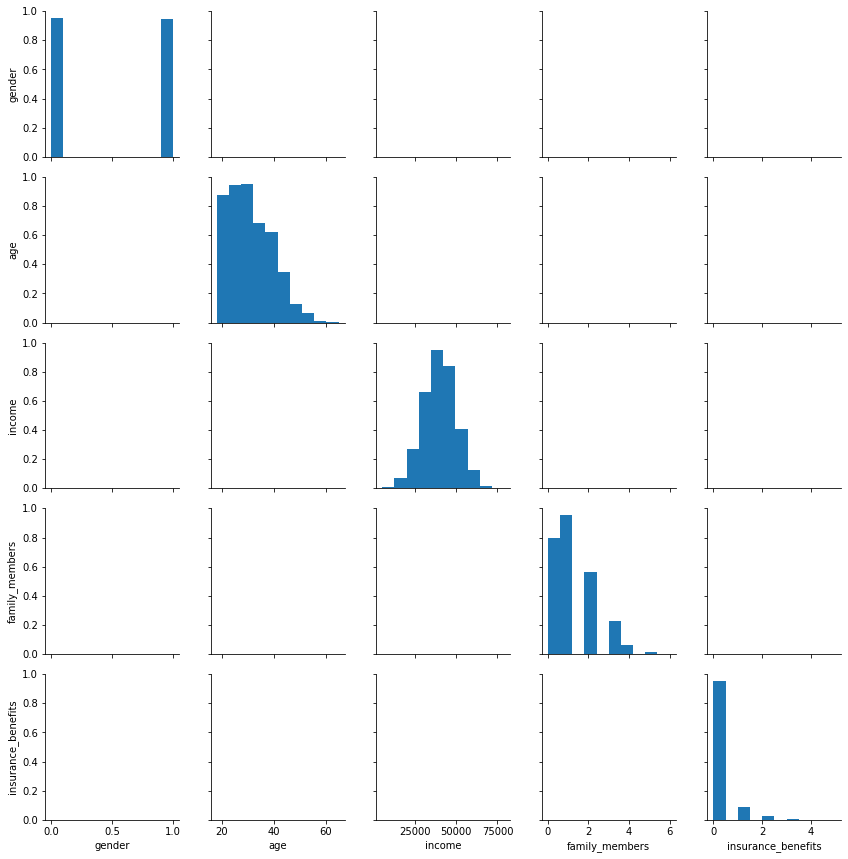

In [10]:
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

Ok, it is a bit difficult to spot obvious groups (clusters) as it is difficult to combine several variables simultaneously (to analyze multivariate distributions). That's where LA and ML can be quite handy.

# Task 1. Similar Customers

In the language of ML, it is necessary to develop a procedure that returns k nearest neighbors (objects) for a given object based on the distance between the objects.

You may want to review the following lessons (chapter -> lesson)
- Distance Between Vectors -> Euclidean Distance
- Distance Between Vectors -> Manhattan Distance

To solve the task, we can try different distance metrics.

Write a function that returns k nearest neighbors for an $n^{th}$ object based on a specified distance metric. The number of received insurance benefits should not be taken into account for this task. 

You can use a ready implementation of the kNN algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors)) or use your own.

Test it for four combination of two cases
- Scaling
  - the data is not scaled
  - the data is scaled with the [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html) scaler
- Distance Metrics
  - Euclidean
  - Manhattan

Answer these questions:
- Does the data being not scaled affect the kNN algorithm? If so, how does that appear?
- How similar are the results using the Manhattan distance metric (regardless of the scaling)?

In [11]:
feature_names = ['gender', 'age', 'income', 'family_members']

In [12]:
def get_knn(df, n, k, metric):
    
    """
    Returns k nearest neighbors

    :param df: pandas DataFrame used to find similar objects within
    :param n: object no for which the nearest neighbours are looked for
    :param k: the number of the nearest neighbours to return
    :param metric: name of distance metric
    """

    nbrs = NearestNeighbors(metric=metric).fit(df[feature_names].values)
    
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], k, return_distance=True)
    
    df_res = pd.concat([
        df.iloc[nbrs_indices[0]], 
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
        ], axis=1)
    
    return df_res

Scaling the data.

In [13]:
feature_names = ['gender', 'age', 'income', 'family_members']

transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

In [14]:
df_scaled.sample(5)

,gender,age,income,family_members,insurance_benefits
1442,1.0,0.307692,0.386076,0.166667,0
4429,0.0,0.569231,0.613924,0.166667,0
781,1.0,0.630769,0.617722,0.000000,0
4729,0.0,0.338462,0.284810,0.000000,0
3088,0.0,0.538462,0.694937,0.000000,0


Now, let's get similar records for a given one for every combination

In [15]:
get_knn(df,2037,4,'euclidean')

,gender,age,income,family_members,insurance_benefits,distance
2037,1,26,36600.0,0,0,0.000000
1508,0,26,36600.0,0,0,1.000000
10,1,25,36600.0,1,0,1.414214
3247,1,26,36600.0,2,0,2.000000


In [16]:
get_knn(df,2037,4,'manhattan') 

,gender,age,income,family_members,insurance_benefits,distance
2037,1,26,36600.0,0,0,0.0
1508,0,26,36600.0,0,0,1.0
3247,1,26,36600.0,2,0,2.0
10,1,25,36600.0,1,0,2.0


In [17]:
get_knn(df_scaled,2037,4,'euclidean')

,gender,age,income,family_members,insurance_benefits,distance
2037,1.0,0.400000,0.463291,0.0,0,0.000000
3481,1.0,0.400000,0.453165,0.0,0,0.010127
19,1.0,0.415385,0.467089,0.0,0,0.015846
3135,1.0,0.384615,0.468354,0.0,0,0.016196


In [18]:
get_knn(df_scaled,2037,4,'manhattan') 

,gender,age,income,family_members,insurance_benefits,distance
2037,1.0,0.400000,0.463291,0.0,0,0.000000
3481,1.0,0.400000,0.453165,0.0,0,0.010127
19,1.0,0.415385,0.467089,0.0,0,0.019182
3135,1.0,0.384615,0.468354,0.0,0,0.020448


Answers to the questions

**Does the data being not scaled affect the kNN algorithm? If so, how does that appear?** 

Data being not scaled DO affect the kNN algorithm.  
It retured results that are farther from the item .  
get_knn(df,1,2,'euclidean') gives a result of observasion number 3920
while
get_knn(df_scaled,1,314,'euclidean').tail(1)
observasion number 3920 is in the k=314  

**distance is not biased towards the income variable when scaling the data**


**How similar are the results using the Manhattan distance metric (regardless of the scaling)?** 

manhattan distance gives the same results as euclidean distance

# Task 2. Is Customer Likely to Receive Insurance Benefit?

In terms of machine learning we can look at this like a binary classification task.

With `insurance_benefits` being more than zero as the target, evaluate whether the kNN classification approach can do better than a dummy model.

Instructions:
- Build a KNN-based classifier and measure its quality with the F1 metric for k=1..10 for both the original data and the scaled one. That'd be interesting to see how k may influece the evaluation metric, and whether scaling the data makes any difference. You can use a ready implemention of the kNN classification algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)) or use your own.
- Build the dummy model which is just random for this case. It should return "1" with some probability. Let's test the model with four probability values: 0, the probability of paying any insurance benefit, 0.5, 1.

The probability of paying any insurance benefit can be defined as

$$
P\{\text{insurance benefit received}\}=\frac{\text{number of clients received any insurance benefit}}{\text{total number of clients}}.
$$

Split the whole data in the 70:30 proportion for the training/testing parts.

In [19]:
# calculate the target

df['insurance_benefits_received'] =df['insurance_benefits'].apply(lambda x: 1 if x >0  else 0)

In [20]:
# check for the class imbalance with value_counts()

# Change 'insurance_benefits' values 2,3,4,5 to 1
df.loc[df['insurance_benefits'] >1,'insurance_benefits'] = 1
df_scaled.loc[df_scaled['insurance_benefits'] >1,'insurance_benefits'] = 1

df['insurance_benefits'].value_counts()

0    4436
1     564
Name: insurance_benefits, dtype: int64

We have an imbalance class 

In [21]:
target = df['insurance_benefits']
features = df[feature_names]

target_scaled = df_scaled['insurance_benefits']
features_scaled = df_scaled[feature_names]

# Split data into train and test
features_train, features_test, target_train, target_test = \
            train_test_split(features, target, test_size=0.3, random_state=RANDOM_STATE)

features_train_scaled, features_test_scaled, target_train_scaled, target_test_scaled = \
            train_test_split(features_scaled, target_scaled, test_size=0.3, random_state=RANDOM_STATE)


In [22]:
def knn(x_train,x_test,y_train,y_test):
    for k in range(1,11):
        neigh = KNeighborsClassifier(n_neighbors=k)
        neigh.fit(x_train,y_train)
        predicted_test = neigh.predict(x_test)
        f1_score = sklearn.metrics.f1_score(y_test, predicted_test)
        print(f'k={k} F1: {f1_score:.2f}')

In [23]:
print('original data')
knn(features_train, features_test, target_train, target_test)

original data
k=1 F1: 0.62
k=2 F1: 0.41
k=3 F1: 0.41
k=4 F1: 0.28
k=5 F1: 0.27
k=6 F1: 0.11
k=7 F1: 0.11
k=8 F1: 0.07
k=9 F1: 0.08
k=10 F1: 0.00


In [24]:
print('scaled data')
knn(features_train_scaled, features_test_scaled, target_train_scaled, target_test_scaled)

scaled data
k=1 F1: 0.97
k=2 F1: 0.93
k=3 F1: 0.95
k=4 F1: 0.91
k=5 F1: 0.92
k=6 F1: 0.90
k=7 F1: 0.92
k=8 F1: 0.90
k=9 F1: 0.92
k=10 F1: 0.88


- F1 score is higher for the scaled data
- As k is greater the F1 score is lower

In [25]:
def eval_classifier(y_true, y_pred):
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1: {f1_score:.2f}')
    
# if you have an issue with the following line, restart the kernel and run the notebook again
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    print('Confusion Matrix')
    print(cm)

In [26]:
# generating output of a random model

def rnd_model_predict(P, size, seed=42):

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

In [27]:
for P in [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]:


    print(f'The probability: {P:.2f}')
    y_pred_rnd =pd.Series(rnd_model_predict(P,len(df)) )
    eval_classifier(df['insurance_benefits_received'], y_pred_rnd)
    
    print()

The probability: 0.00
F1: 0.00
Confusion Matrix
[[0.8872 0.    ]
 [0.1128 0.    ]]

The probability: 0.11
F1: 0.12
Confusion Matrix
[[0.7914 0.0958]
 [0.0994 0.0134]]

The probability: 0.50
F1: 0.20
Confusion Matrix
[[0.456  0.4312]
 [0.053  0.0598]]

The probability: 1.00
F1: 0.20
Confusion Matrix
[[0.     0.8872]
 [0.     0.1128]]



- Our model is better than the dummy model

# Task 3. Regression (with Linear Regression)

With `insurance_benefits` as the target, evaluate what RMSE would be for a Linear Regression model.

Build your own implementation of LR. For that, recall how the linear regression task's solution is formulated in terms of LA. Check RMSE for both the original data and the scaled one. Can you see any difference in RMSE between these two cases?

Let's denote
- $X$ — feature matrix, each row is a case, each column is a feature, the first column consists of unities
- $y$ — target (a vector)
- $\hat{y}$ — estimated tagret (a vector)
- $w$ — weight vector

The task of linear regression in the language of matrices can be formulated as

$$
y = Xw
$$

The training objective then is to find such $w$ that it would minimize the L2-distance (MSE) between $Xw$ and $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

It appears that there is analytical solution for the above:

$$
w = (X^T X)^{-1} X^T y
$$

The formula above can be used to find the weights $w$ and the latter can be used to calculate predicted values

$$
\hat{y} = X_{val}w
$$

Split the whole data in the 70:30 proportion for the training/validation parts. Use the RMSE metric for the model evaluation.

In [28]:
class MyLinearRegression:
    
    def __init__(self):
        
        self.weights = None
        
    
    def fit(self, X, y):
        
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        w = np.linalg.inv(X2.T.dot(X2)).dot(X2.T).dot(y)
        self.weights = w

    def predict(self, X):
        
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        y_pred = X2.dot(self.weights)
        
        return y_pred

In [29]:
def eval_regressor(y_true, y_pred):
    
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')
    
    r2_score = math.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
    print(f'R2: {r2_score:.2f}')    

In [30]:
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-6.50583302e-01  2.47409374e-02 -7.31018901e-04  1.36927859e-07
 -6.32915410e-03]
RMSE: 0.23
R2: 0.66


In [31]:
#Scaled data

X = df_scaled[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df_scaled['insurance_benefits'].to_numpy()

# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-6.50583302e-01  1.60816093e+00 -7.31018901e-04  1.08173008e-02
 -3.79749246e-02]
RMSE: 0.23
R2: 0.66


RMSE and R2 Matrices are the same for the original data and the scaled data.

# Task 4. Obfuscating Data

It best to obfuscate data by multiplying the numerical features (remember, they can be seen as the matrix $X$) by an invertible matrix $P$. 

$$
X' = X \times P
$$

Try to do that and check how the features' values will look like after the transformation. By the way, the intertible property is important here so make sure that $P$ is indeed invertible.

You may want to review the 'Matrices and Matrix Operations -> Matrix Mupliplication' lesson to recall the rule of matrix multiplication and its implementation with NumPy.

In [32]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]

In [33]:
X = df_pn.to_numpy()

Generating a random matrix $P$.

In [34]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

Checking the matrix $P$ is invertible

In [35]:
np.linalg.det(P)

0.24339135998015463

The P matrix is invertible(the determinant is not 0)

In [36]:
P.dot(np.linalg.inv(P))

array([[ 1.00000000e+00,  1.85130588e-16, -2.97856902e-16,
        -3.91584367e-17],
       [ 6.23834470e-17,  1.00000000e+00, -7.10568689e-17,
         8.24459807e-17],
       [ 1.03941594e-17,  2.27454503e-17,  1.00000000e+00,
        -5.77784356e-17],
       [-1.02697151e-16, -1.69379178e-16, -2.49945035e-17,
         1.00000000e+00]])

There are ones along the main diagonal and zeros(almost, a very small numbers close to 0) everywhere else

In [37]:
#obfuscate the data
X_obfuscate = X.dot(P)
X_obfuscate

array([[ 6359.71527314, 22380.40467609, 18424.09074184, 46000.69669016],
       [ 4873.29406479, 17160.36702982, 14125.78076133, 35253.45577301],
       [ 2693.11742928,  9486.397744  ,  7808.83156024, 19484.86063067],
       ...,
       [ 4346.2234249 , 15289.24126492, 12586.16264392, 31433.50888552],
       [ 4194.09324155, 14751.9910242 , 12144.02930637, 30323.88763426],
       [ 5205.46827354, 18314.24814446, 15077.01370762, 37649.59295455]])

Can you guess the customers' ages or income after the transformation?

No.

Can you recover the original data from $X'$ if you know $P$? Try to check that with calculations by moving $P$ from the right side of the formula above to the left one. The rules of matrix multiplcation are really helpful here.

In [38]:
# Getting the original data
X_reversed = X_obfuscate.dot(np.linalg.inv(P))
X_reversed

array([[ 1.00000000e+00,  4.10000000e+01,  4.96000000e+04,
         1.00000000e+00],
       [ 1.67952800e-12,  4.60000000e+01,  3.80000000e+04,
         1.00000000e+00],
       [-6.23021448e-13,  2.90000000e+01,  2.10000000e+04,
        -2.03032656e-13],
       ...,
       [ 1.57996161e-12,  2.00000000e+01,  3.39000000e+04,
         2.00000000e+00],
       [ 1.00000000e+00,  2.20000000e+01,  3.27000000e+04,
         3.00000000e+00],
       [ 1.00000000e+00,  2.80000000e+01,  4.06000000e+04,
         1.00000000e+00]])

Print all three cases for a few customers
- The original data
- The transformed one
- The reversed (recovered) one

In [39]:
# Print all three cases for a customer
def show_data(index):
    data = [[X[index][0],X[index][1],X[index][2],X[index][3]],
            [X_obfuscate[index][0],X_obfuscate[index][1],X_obfuscate[index][2],X_obfuscate[index][3]],
            [X_reversed[index][0],X_reversed[index][1],X_reversed[index][2],X_reversed[index][3]]
           ]
    return  pd.DataFrame(data,index=['original','transformed','reversed'],columns=['age', 'gender', 'income', 'family_members'])
    

In [40]:
#Show data for index=1
show_data(1)

,age,gender,income,family_members
original,0.000000e+00,46.00000,38000.000000,1.000000
transformed,4.873294e+03,17160.36703,14125.780761,35253.455773
reversed,1.679528e-12,46.00000,38000.000000,1.000000


In [41]:
#Show data for index=10
show_data(10)

,age,gender,income,family_members
original,1.000000,25.000000,36600.000000,1.000000
transformed,4692.731211,16509.777526,13591.538192,33940.174806
reversed,1.000000,25.000000,36600.000000,1.000000


In [42]:
#Show data for index=3
show_data(3)

,age,gender,income,family_members
original,0.000000e+00,21.000000,41700.000000,2.000000
transformed,5.345604e+03,18803.227203,15479.148373,38663.061863
reversed,-1.089078e-12,21.000000,41700.000000,2.000000


You can probably see that some values are not exactly the same as they are in the original data. What might be the reason for that?

For a value of 0 in the original data, the reversed data gives a very small number close to 0.
The reason for that is issue  with the floating point accuracy.

## Proof That Data Obfuscation Can Work with LR

The regression task has been solved with linear regression in this project. Your next task is to prove _analytically_ that the given obfuscation method won't affect linear regression in terms of predicted values i.e. their values will remain the same. Can you believe that? Well, you don't have to, you should prove it!

So, the data is obfuscated and there is $X \times P$ instead of just $X$ now. Consequently, there are other weights $w_P$ as
$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

How would $w$ and $w_P$ be linked if you simplify the formula for $w_P$ above? 

What would be predicted values with $w_P$? 

What does that mean for the quality of linear regression if you measure it with RMSE?

Check Appendix B Properties of Matrices in the end of the notebook. There are useful formulas in there!

No code is necessary in this section, only analytical explanation!

**Answer**

- predicted values should be the same
- quality of linear regression should be the same 


**Analytical proof**

$
w_P = [P^TX^T XP]^{-1}P^TX^T y
$

$
w_P = P^{-1} (X^T X)^{-1} (P^T)^{-1} P^TX^T y
$


$
(P^T)^{-1} P^T =I
$

$
w_P = P^{-1} (X^T X)^{-1} X^T y
$

$
w = (X^T X)^{-1} X^T y
$

$
w_P =  P^{-1}w
$

$
\hat{y}_P = X_Pw_P
$

$
\hat{y_P} = XP P^{-1}w
$

$
P P^{-1} = I
$

$
\hat{y_P} = Xw
$

## Test Linear Regression With Data Obfuscation

Now, let's prove Linear Regression can work computationally with the chosen obfuscation transformation.

Build a procedure or a class that runs Linear Regression optionally with the obfuscation. You can use either a ready implementation of Linear Regression from sciki-learn or your own.

Run Linear Regression for the original data and the obfuscated one, compare the predicted values and the RMSE, $R^2$ metric values. Is there any difference?

**Procedure**

- Create a square matrix $P$ of random numbers.
- Check that it is invertible. If not, repeat the first point until we get an invertible matrix.
- <! your comment here !>
- Use $XP$ as the new feature matrix

In [43]:

def Linear_Regression(features_train,features_test, target_train,target_test):
    reg = LinearRegression()
    reg.fit(features_train, target_train)
    predict = reg.predict(features_test)
    eval_regressor(target_test,predict)
    

# Generating a random matrix
#Check that it is invertible. If not, repeat until we get an invertible matrix.
def rnd_matrix(size, seed=42):
    while True:
        rng = np.random.default_rng(seed=seed)
        P =  rng.random(size=(size,size))
        if(np.linalg.det(P) != 0):
            break;
            
    return P
    
#evaluation matrices
def eval_regressor(y_true, y_pred):

    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')

    r2_score = math.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
    print(f'R2: {r2_score:.2f}')   


In [44]:
feature_names = ['gender', 'age', 'income', 'family_members']

P = rnd_matrix(df.shape[1])

#obfuscate the data
df_obfuscate = df.dot(P)

target_obfuscate = df_obfuscate.loc[:,4].to_numpy()
features_obfuscate = df_obfuscate.loc[:,range(0,3)].to_numpy()

# Split data into train and test
features_train_obfuscate, features_test_obfuscate, target_train_obfuscate, target_test_obfuscate = \
            train_test_split(features_obfuscate, target_obfuscate, test_size=0.3, random_state=RANDOM_STATE)


In [45]:
feature_names = ['gender', 'age', 'income', 'family_members']

# Generating a random matrix
P = rnd_matrix(df[feature_names].shape[1])

#obfuscate the data
features_obfuscate = df[feature_names].dot(P)

target = df['insurance_benefits'].to_numpy()

# Split data into train and test
features_train_obfuscate, features_test_obfuscate, target_train, target_test = \
            train_test_split(features_obfuscate, target, test_size=0.3, random_state=RANDOM_STATE)


In [46]:
print('obfuscate data')
print('---------------')
Linear_Regression(features_train_obfuscate, features_test_obfuscate, target_train, target_test)
print()
print('original data')
print('---------------')
Linear_Regression(features_train, features_test, target_train, target_test)

obfuscate data
---------------
RMSE: 0.23
R2: 0.66

original data
---------------
RMSE: 0.23
R2: 0.66


# Conclusions

- F1 score is higher for the scaled data
- As k is greater the F1 score is lower
- Our model is better than the dummy model
-  Linear Regression can work with the original data and the obfuscated one.
   RMSE, 𝑅2  metric values are the same for both data
   

# Appendices 

## Appendix A: Writing Formulas in Jupyter Notebooks

You can write formulas in your Jupyter Notebook in a markup language provided by a high-quality publishing system called $\LaTeX$ (pronounced "Lah-tech"), and they will look like formulas in textbooks.

To put a formula in a text, put the dollar sign (\\$) before and after the formula's text e.g. $\frac{1}{2} \times \frac{3}{2} = \frac{3}{4}$ or $y = x^2, x \ge 1$.

If a formula should be in its own paragraph, put the double dollar sign (\\$\\$) before and after the formula text e.g.

$$
\bar{x} = \frac{1}{n}\sum_{i=1}^{n} x_i.
$$

The markup language of [LaTeX](https://en.wikipedia.org/wiki/LaTeX) is very popular among people who use formulas in their articles, books and texts. It can be complex but its basics are easy. Check this two page [cheatsheet](http://tug.ctan.org/info/undergradmath/undergradmath.pdf) for learning how to compose the most common formulas.

## Appendix B: Properties of Matrices

Matrices have many properties in Linear Algebra. A few of them are listed here which can help with the analytical proof in this project.

<table>
<tr>
<td>Distributivity</td><td>$A(B+C)=AB+AC$</td>
</tr>
<tr>
<td>Non-commutativity</td><td>$AB \neq BA$</td>
</tr>
<tr>
<td>Associative property of multiplication</td><td>$(AB)C = A(BC)$</td>
</tr>
<tr>
<td>Multiplicative identity property</td><td>$IA = AI = A$</td>
</tr>
<tr>
<td></td><td>$A^{-1}A = AA^{-1} = I$
</td>
</tr>    
<tr>
<td></td><td>$(AB)^{-1} = B^{-1}A^{-1}$</td>
</tr>    
<tr>
<td>Reversivity of the transpose of a product of matrices,</td><td>$(AB)^T = B^TA^T$</td>
</tr>    
</table>